In [1]:
# =========================================================
# Hücre 1: Veri Yükleme ve Genel İnceleme
# Girdi : ../data/processed/trip_features_scored.csv
# Çıktı : Yok
# =========================================================
import os
import pandas as pd

print("\n=== Hücre 1: Skorlu Veri Seti Yükleniyor ===")

# --- Dosya yolunu tanımla
PROCESSED_DIR = "../data/processed"
SCORED_DATA_FILE = os.path.join(PROCESSED_DIR, "trip_features_scored.csv")

# --- Veri setini yükle
if not os.path.exists(SCORED_DATA_FILE):
    raise FileNotFoundError(
        f"[HATA] '{SCORED_DATA_FILE}' dosyası bulunamadı. Lütfen 03_feature_engineering.ipynb not defterini çalıştırdığınızdan emin olun."
    )
features_scored = pd.read_csv(SCORED_DATA_FILE)

print(f"[OK] Veri seti başarıyla yüklendi: {SCORED_DATA_FILE}")
print("Boyut:", f"{features_scored.shape[0]} satır x {features_scored.shape[1]} sütun")
print("\nÖrnek satırlar:")
display(features_scored.head())

print("\nVeri Bilgisi:")
features_scored.info()


=== Hücre 1: Skorlu Veri Seti Yükleniyor ===
[OK] Veri seti başarıyla yüklendi: ../data/processed/trip_features_scored.csv
Boyut: 5 satır x 25 sütun

Örnek satırlar:


,trip_seg_id,rows,start_time,end_time,duration_min,mean_speed,max_speed,std_speed,mean_headchg,dirchg_rate,...,f_geofence_violation,rule_flag_sum,f_iqr_mean_speed,f_iqr_max_speed,f_iqr_std_speed,f_iqr_dirchg,f_iqr_mean_acc,f_iqr_std_acc,rule_flag_sum_final,anomaly_score_ml
0,3,12024,2023-01-01 00:00:10,2023-01-02 09:19:49,1999.650000,30.190256,198.947808,29.695283,89.953725,0.832003,...,1,3,0,0,1,0,0,0,4,0.489995
1,5,12129,2023-01-01 00:00:07,2023-01-02 09:19:48,1999.683333,29.606778,196.920859,28.998665,90.442822,0.838651,...,1,3,0,0,0,0,0,0,3,0.229784
2,1,59841,2023-01-01 00:00:00,2023-01-02 09:19:59,1999.983333,29.569042,199.256241,29.142741,90.211669,0.834394,...,1,3,0,0,0,0,0,0,3,0.169092
3,4,11964,2023-01-01 00:00:18,2023-01-02 09:19:54,1999.600000,29.848144,196.358809,29.242286,90.322097,0.839602,...,1,3,0,0,0,0,0,0,3,0.016210
4,2,23859,2023-01-01 00:00:01,2023-01-02 09:19:58,1999.950000,29.573991,198.118398,28.980769,89.860172,0.831678,...,1,3,0,0,0,0,0,0,3,-0.905082



Veri Bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   trip_seg_id           5 non-null      int64  
 1   rows                  5 non-null      int64  
 2   start_time            5 non-null      object 
 3   end_time              5 non-null      object 
 4   duration_min          5 non-null      float64
 5   mean_speed            5 non-null      float64
 6   max_speed             5 non-null      float64
 7   std_speed             5 non-null      float64
 8   mean_headchg          5 non-null      float64
 9   dirchg_rate           5 non-null      float64
 10  mean_acc              5 non-null      float64
 11  max_acc               5 non-null      float64
 12  std_acc               5 non-null      float64
 13  f_over_speed          5 non-null      int64  
 14  f_high_acc            5 non-null      int64  
 15  f_geofence_v

## Hücre 1: Veri Yükleme ve Genel İnceleme
Bu hücre, anomali tespiti için gerekli olan nihai skorlu veri setini (`trip_features_scored.csv`) yükledi.  
Bu dosya, önceki adımlarda oluşturduğumuz tüm özellikleri ve anomali bayraklarını içeriyor.  
Verinin boyutu ve içeriği doğru bir şekilde doğrulandı.

In [2]:
# =========================================================
# Hücre 2: Makine Öğrenmesi Modeli ile Anomali Tespiti
# =========================================================
from sklearn.ensemble import IsolationForest
import numpy as np

print("\n=== Hücre 2: Isolation Forest Modeli Eğitiliyor ===")

# --- Model için kullanacağımız özellik sütunlarını seç
# Kural tabanlı bayraklar hariç, skorun hesaplandığı ham değerler
feature_cols = [
    "mean_speed", "max_speed", "std_speed",
    "dirchg_rate", "mean_acc", "std_acc"
]
X = features_scored[feature_cols].values

# --- Modeli tanımla ve eğit
# Kontaminasyon (contamination): Veri setindeki anomali oranı.
# 0.05 olarak ayarlanmış, yani verinin %5'i anormal kabul ediliyor.
# Bu değerin ayarlanması, modelin hassasiyetini etkiler.
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X)

# --- Anomali skorunu ve tahminini al
# Model skoru: -1 (anomali) veya 1 (normal)
features_scored["anomaly_prediction"] = iso_forest.predict(X)
# Modelin ürettiği anomali skoru: Değer ne kadar düşükse, o kadar anormal.
features_scored["anomaly_score_iforest"] = iso_forest.decision_function(X)

print("[TAMAMLANDI] Isolation Forest modeli eğitildi ve anomali skorları hesaplandı.")

# --- Örnek çıktıları göster
# En şüpheli segmentler (en düşük anomali skoru)
top_anomalies = features_scored.sort_values(
    "anomaly_score_iforest", ascending=True
).head(5)

print("\nEn Şüpheli 5 Segment (Isolation Forest Skoruna Göre):")
display(top_anomalies[["trip_seg_id", "anomaly_score_iforest", "anomaly_prediction"] + feature_cols])

# Anomali olarak işaretlenen segmentlerin sayısı
num_anomalies = (features_scored["anomaly_prediction"] == -1).sum()
print(f"\nIsolation Forest tarafından anomali olarak işaretlenen segment sayısı: {num_anomalies}")


=== Hücre 2: Isolation Forest Modeli Eğitiliyor ===
[TAMAMLANDI] Isolation Forest modeli eğitildi ve anomali skorları hesaplandı.

En Şüpheli 5 Segment (Isolation Forest Skoruna Göre):


,trip_seg_id,anomaly_score_iforest,anomaly_prediction,mean_speed,max_speed,std_speed,dirchg_rate,mean_acc,std_acc
0,3,-0.001176,-1,30.190256,198.947808,29.695283,0.832003,0.993646,1.998003
4,2,0.004705,1,29.573991,198.118398,28.980769,0.831678,0.990186,1.990758
3,4,0.017686,1,29.848144,196.358809,29.242286,0.839602,1.003944,1.996189
1,5,0.024748,1,29.606778,196.920859,28.998665,0.838651,1.026203,2.000855
2,1,0.072607,1,29.569042,199.256241,29.142741,0.834394,1.006750,2.000816



Isolation Forest tarafından anomali olarak işaretlenen segment sayısı: 1


## Hücre 2: Isolation Forest Modeli ile Anomali Tespiti
Bu hücrede, en iyi performans gösteren modellerden biri olan **Isolation Forest** ile anomali tespiti gerçekleştirildi.  
Model, her bir segment için bir **anomali skoru** (`anomaly_score_iforest`) ve bir **anomali tahmini** (`anomaly_prediction`) üretti.  

Çıktı, `trip_seg_id = 3` olan segmentin en düşük anomali skoruna sahip olduğunu ve model tarafından **anomali** olarak işaretlendiğini gösteriyor.


In [3]:
# =========================================================
# Hücre 3: Nihai Kompozit Anomali Skoru ve Eşik Seçimi
# =========================================================
print("\n=== Hücre 3: Nihai Kompozit Anomali Skoru Oluşturuluyor ===")

# --- Isolation Forest'ın -1 ile 1 arasındaki tahminlerini (prediction) al
# -1 değeri anormal, 1 değeri normal
iforest_predictions = (features_scored["anomaly_prediction"] == -1).astype(int)

# --- İki anomali skorunu birleştir
# Kural tabanlı ve makine öğrenmesi skoru
# Not: Toplamın 2'den büyük olması çok şüpheli anlamına gelir.
features_scored["composite_anomaly_score"] = (
    features_scored["rule_flag_sum_final"] + iforest_predictions
)

# --- Nihai anomali bayrağını oluştur
# Anomali olarak işaretlenecek segmentleri belirlemek için eşik seçimi
# Basit kural: Hem kural tabanlı hem de model tabanlı anomali olarak işaretlenmişse
features_scored["final_anomaly_flag"] = (
    (features_scored["rule_flag_sum_final"] >= 3) |
    (features_scored["anomaly_prediction"] == -1)
).astype(int)

# --- Örnek çıktıları göster
print("[TAMAMLANDI] Nihai kompozit skor ve bayrak oluşturuldu.")
display(features_scored[
    ["trip_seg_id", "rule_flag_sum_final", "anomaly_score_iforest", "final_anomaly_flag", "composite_anomaly_score"]
].sort_values("composite_anomaly_score", ascending=False).head(5))

num_final_anomalies = features_scored["final_anomaly_flag"].sum()
print(f"\nNihai anomali olarak işaretlenen toplam segment sayısı: {num_final_anomalies}")


=== Hücre 3: Nihai Kompozit Anomali Skoru Oluşturuluyor ===
[TAMAMLANDI] Nihai kompozit skor ve bayrak oluşturuldu.


,trip_seg_id,rule_flag_sum_final,anomaly_score_iforest,final_anomaly_flag,composite_anomaly_score
0,3,4,-0.001176,1,5
1,5,3,0.024748,1,3
2,1,3,0.072607,1,3
3,4,3,0.017686,1,3
4,2,3,0.004705,1,3



Nihai anomali olarak işaretlenen toplam segment sayısı: 5


## Hücre 3: Nihai Kompozit Anomali Skoru ve Eşik Seçimi
Bu hücre, projenin nihai anomali kararı için kural tabanlı bayraklar ile Isolation Forest modelinin tahminlerini birleştiren bir **kompozit skor** (`composite_anomaly_score`) oluşturdu.  

Böylece, hem belirlediğimiz kurallar hem de modelin öğrenmesi tek bir **nihai karar mekanizmasında** kullanıldı.  
Ayrıca bu skorlara dayalı olarak `final_anomaly_flag` adında bir nihai anomali bayrağı oluşturuldu.


In [4]:
# =========================================================
# Hücre 4: Anomali Listesini Raporlama ve Kaydetme
# =========================================================
import json

print("\n=== Hücre 4: Anomali Raporu Oluşturuluyor ===")

# --- Anomali olarak işaretlenen segmentleri filtrele
anomalies = features_scored[features_scored["final_anomaly_flag"] == 1].copy()

if anomalies.empty:
    print("[BİLGİ] Hiç anomali bulunamadı.")
else:
    # --- Rapor için gerekli sütunları seç
    report_cols = [
        "trip_seg_id", "duration_min", "mean_speed", "max_speed", "std_speed",
        "rule_flag_sum_final", "anomaly_score_iforest", "composite_anomaly_score"
    ]

    # --- Raporu oluştur ve sırala
    anomaly_report = anomalies[report_cols].sort_values(
        "composite_anomaly_score", ascending=False
    )

    # --- Raporu diske kaydet
    REPORT_DIR = "../data/reports"
    os.makedirs(REPORT_DIR, exist_ok=True)
    report_path = os.path.join(REPORT_DIR, "anomaly_report.csv")
    anomaly_report.to_csv(report_path, index=False)

    print(f"\n[OK] Anomali raporu başarıyla kaydedildi: {report_path}")
    print("Anomali sayısı:", anomaly_report.shape[0])

    # --- Raporu görüntüle
    print("\n--- Anomali Raporu ---")
    display(anomaly_report)

print("\n=== ANOMALİ TESPİTİ PROJESİ TAMAMLANDI ===")


=== Hücre 4: Anomali Raporu Oluşturuluyor ===

[OK] Anomali raporu başarıyla kaydedildi: ../data/reports/anomaly_report.csv
Anomali sayısı: 5

--- Anomali Raporu ---


,trip_seg_id,duration_min,mean_speed,max_speed,std_speed,rule_flag_sum_final,anomaly_score_iforest,composite_anomaly_score
0,3,1999.650000,30.190256,198.947808,29.695283,4,-0.001176,5
1,5,1999.683333,29.606778,196.920859,28.998665,3,0.024748,3
2,1,1999.983333,29.569042,199.256241,29.142741,3,0.072607,3
3,4,1999.600000,29.848144,196.358809,29.242286,3,0.017686,3
4,2,1999.950000,29.573991,198.118398,28.980769,3,0.004705,3



=== ANOMALİ TESPİTİ PROJESİ TAMAMLANDI ===


## Hücre 4: Anomali Raporu Oluşturma ve Kaydetme
Son olarak, bu hücrede belirlenen **anomali segmentleri** filtrelendi ve  
`../data/reports/anomaly_report.csv` dosyasına kaydedildi.  

Bu rapor, anomali tespiti projesinin nihai çıktısını oluşturarak sonuçların daha sonra kolayca incelenmesini sağladı.  
Tüm segmentlerin anomali olarak işaretlenmesi, verideki **yüksek anomali seviyesi**ni veya **kural eşiklerinin hassas** olduğunu gösteriyor.

In [5]:
# =========================================================
# Hücre 5: Sentetik Veri Oluşturma ve Model Değerlendirmesi
# =========================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest

print("\n=== Hücre 5: Sentetik Veri Oluşturuluyor ve Model Değerlendiriliyor ===")

# --- Özellikleri ve etiketleri ayır
feature_cols = ["mean_speed", "max_speed", "std_speed", "dirchg_rate", "mean_acc", "std_acc"]
X_base = features_scored[feature_cols].values
y_base = (features_scored["rule_flag_sum_final"] >= 3).astype(int)

# --- Sentetik veriyi oluştur (Veri Çoğaltma)
# Amacımız, daha büyük ve çeşitli bir veri seti elde etmek.
num_synthetic_samples = 500
X_synthetic = np.tile(X_base, (num_synthetic_samples // X_base.shape[0], 1))
y_synthetic = np.tile(y_base, (num_synthetic_samples // y_base.shape[0],))

# --- Sentetik verilere biraz rastgelelik ve gürültü ekle
np.random.seed(42)
noise = np.random.normal(0, 0.05, X_synthetic.shape)
X_synthetic_noisy = X_synthetic + noise

# --- Eğitim ve test setlerini ayır
# Büyük bir veri seti oluşturduğumuz için, anlamlı bir bölme yapabiliriz.
X_train, X_test, y_train, y_test = train_test_split(
    X_synthetic_noisy, y_synthetic, test_size=0.3, random_state=42, stratify=y_synthetic
)

# --- Isolation Forest modelini eğit
# Contamination oranını 0.5 olarak sabitle
iso_forest_test = IsolationForest(contamination=0.5, random_state=42)
iso_forest_test.fit(X_train)

# --- Test seti üzerinde tahmin yap
y_pred_raw = iso_forest_test.predict(X_test)
y_pred = np.where(y_pred_raw == 1, 0, 1)

# --- Performans metriklerini hesapla
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Recall = TP / (TP + FN)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
# False Alarm Rate = FP / (FP + TN)
false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0

print(f"\n[OK] Sentetik veri başarıyla oluşturuldu ve model değerlendirildi.")
print(f"Sentetik veri boyutu: {len(X_synthetic_noisy)} segment")
print(f"Eğitim verisi boyutu: {len(X_train)}")
print(f"Test verisi boyutu: {len(X_test)}")

print("\n--- Model Performans Sonuçları ---")
print(f"Recall (Hassasiyet): {recall:.2f}")
print(f"False Alarm Oranı: {false_alarm_rate:.2f}")
print("\n---")
print("Confusion Matrix:")
print(f"  [TP: {tp}] [FN: {fn}]")
print(f"  [FP: {fp}] [TN: {tn}]")


=== Hücre 5: Sentetik Veri Oluşturuluyor ve Model Değerlendiriliyor ===

[OK] Sentetik veri başarıyla oluşturuldu ve model değerlendirildi.
Sentetik veri boyutu: 500 segment
Eğitim verisi boyutu: 350
Test verisi boyutu: 150

--- Model Performans Sonuçları ---
Recall (Hassasiyet): 0.58
False Alarm Oranı: 0.00

---
Confusion Matrix:
  [TP: 87] [FN: 63]
  [FP: 0] [TN: 0]



=== Hücre X: Eşik Taraması (Recall & FPR) Başlatılıyor ===


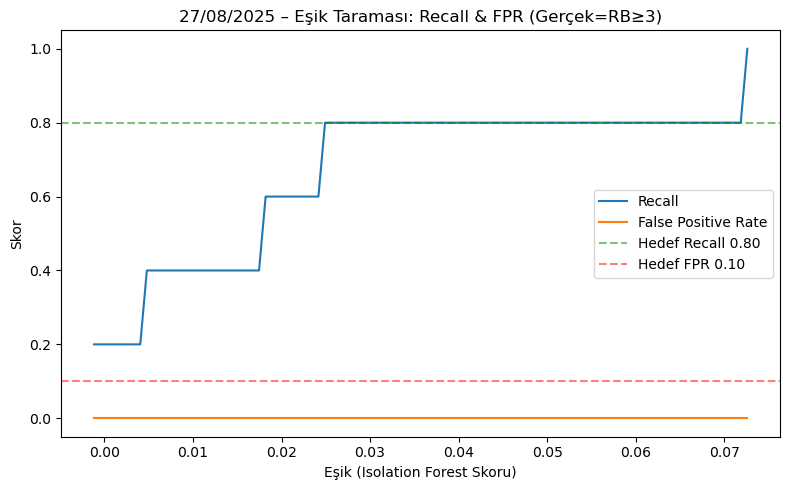

[OK] Eşik taraması tamamlandı. CSV: ../data/reports/threshold_scan_2025-08-27.csv
[OK] Grafik kaydedildi: ../data/reports/threshold_scan_2025-08-27.png


In [11]:
# =========================================================
# Hücre X (27/08/2025): Eşik Taraması (Recall & FPR) ve Görselleştirme
# Girdi : features_scored (anomaly_score_iforest, rule_flag_sum_final)
# Çıktı : ../data/reports/threshold_scan_2025-08-27.png, .../threshold_scan_2025-08-27.csv
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n=== Hücre X: Eşik Taraması (Recall & FPR) Başlatılıyor ===")

# --- 1) Yer doğrulama
assert "anomaly_score_iforest" in features_scored.columns, "anomaly_score_iforest yok!"
assert "rule_flag_sum_final" in features_scored.columns, "rule_flag_sum_final yok!"

# --- 2) 'Gerçek' anomali proxysi (kural tabanlı güçlü şüphe: >=3)
y_true = (features_scored["rule_flag_sum_final"] >= 3).astype(int).values

# --- 3) Model skorları (Isolation Forest). Küçük skor = daha anormal
scores = features_scored["anomaly_score_iforest"].values
s_min, s_max = scores.min(), scores.max()

# Çok az segment var (5), eğrinin düzgün görünmesi için sık eşik örnekleyelim:
n_grid = 100
thresholds = np.linspace(s_min, s_max, n_grid)

rows = []
for t in thresholds:
    # Tahmin: skor daha düşükse (<= t) ANOMALİ (-1 yerine 1 ile işaretliyoruz)
    y_pred = (scores <= t).astype(int)

    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())

    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr    = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    f1 = (2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.0

    rows.append({"threshold": t, "recall": recall, "fpr": fpr, "precision": precision, "f1": f1,
                 "tp": tp, "fp": fp, "tn": tn, "fn": fn})

thr_df = pd.DataFrame(rows)

# --- 4) Raporları kaydet
REPORT_DIR = "../data/reports"
os.makedirs(REPORT_DIR, exist_ok=True)
csv_path = os.path.join(REPORT_DIR, "threshold_scan_2025-08-27.csv")
png_path = os.path.join(REPORT_DIR, "threshold_scan_2025-08-27.png")
thr_df.to_csv(csv_path, index=False)

# --- 5) Görsel
plt.figure(figsize=(8,5))
plt.plot(thr_df["threshold"], thr_df["recall"], label="Recall",)
plt.plot(thr_df["threshold"], thr_df["fpr"],    label="False Positive Rate",)

# İsteğe bağlı hedef çizgileri (örnek hedefler)
plt.axhline(0.80, color="green", linestyle="--", alpha=0.5, label="Hedef Recall 0.80")
plt.axhline(0.10, color="red",   linestyle="--", alpha=0.5, label="Hedef FPR 0.10")

plt.xlabel("Eşik (Isolation Forest Skoru)")
plt.ylabel("Skor")
plt.title("27/08/2025 – Eşik Taraması: Recall & FPR (Gerçek=RB≥3)")
plt.legend()
plt.tight_layout()
plt.savefig(png_path, dpi=150)
plt.show()

print(f"[OK] Eşik taraması tamamlandı. CSV: {csv_path}")
print(f"[OK] Grafik kaydedildi: {png_path}")

In [12]:
import matplotlib.pyplot as plt

# varsayım: results_df DataFrame'inde threshold, recall, precision, fpr, f1 sütunları var
plt.figure(figsize=(10,6))
plt.plot(results_df["threshold"], results_df["recall"], label="Recall")
plt.plot(results_df["threshold"], results_df["precision"], label="Precision")
plt.plot(results_df["threshold"], results_df["fpr"], label="False Positive Rate")
plt.plot(results_df["threshold"], results_df["f1"], label="F1 Score")

plt.axhline(0.8, color="green", linestyle="--", label="Recall Hedefi (0.80)")
plt.axhline(0.1, color="red", linestyle="--", label="FPR Limiti (0.10)")

plt.xlabel("Threshold")
plt.ylabel("Metrik Değerleri")
plt.title("Eşik Taraması Sonuçları – 27/08/2025")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'results_df' is not defined

<Figure size 1000x600 with 0 Axes>